/usr/local/lib/python3.11/dist-packages/scipy/optimize/_minimize.py:733: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.000793
         Iterations: 500
         Function evaluations: 549
         Gradient evaluations: 549

Final MSE on training data: 0.001586


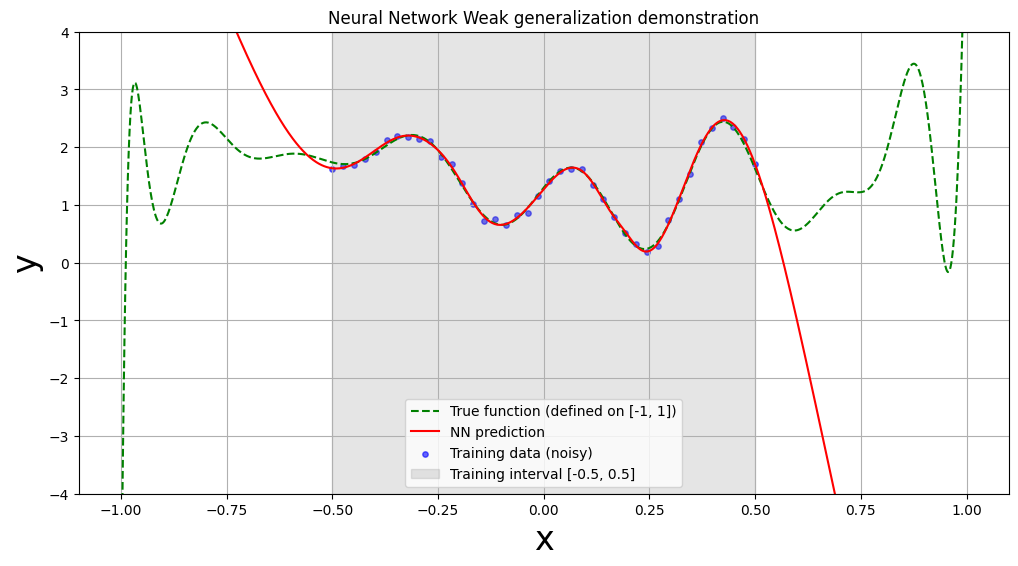

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import Legendre

# -----------------------------------------------------
# Training data configuration
# -----------------------------------------------------
n = 40
low = -0.5
high = 0.5
sampling_type_train = 'uniform'
d_true = 20
data_basis_type = 'legendre'
c_true = np.random.randn(d_true + 1)
noise_mean = 0.0
noise_std = 0.05

# Global domain for true function
true_domain_min = -1
true_domain_max = 1

# -----------------------------------------------------
# Data generation utilities
# -----------------------------------------------------
def generate_x(n, low, high, sampling_type_train):
    return np.linspace(low, high, n).reshape(-1, 1)

def design_matrix(x, d_true, data_basis_type, x_min=None, x_max=None):
    n, _ = x.shape
    x_flat = x.flatten()

    if data_basis_type == 'poly':
        return np.hstack([x ** i for i in range(d_true + 1)])

    elif data_basis_type == 'legendre':
        # Use provided scaling bounds
        if x_min is None:
            x_min = x_flat.min()
        if x_max is None:
            x_max = x_flat.max()
        x_scaled = 2 * (x_flat - x_min) / (x_max - x_min) - 1
        mat = np.zeros((n, d_true + 1))
        for i in range(d_true + 1):
            P = Legendre.basis(i)
            mat[:, i] = P(x_scaled)
        return mat

    elif data_basis_type == 'fourier':
        mat = np.zeros((n, d_true + 1))
        mat[:, 0] = 1
        for k in range(1, (d_true + 1) // 2 + 1):
            mat[:, 2 * k - 1] = np.sin(2 * np.pi * k * x_flat)
            if 2 * k < d_true + 1:
                mat[:, 2 * k] = np.cos(2 * np.pi * k * x_flat)
        return mat

    elif data_basis_type == 'tanh':
        mat = np.zeros((n, d_true + 1))
        for i in range(d_true + 1):
            mat[:, i] = np.tanh((i + 1) * x_flat)
        return mat

    else:
        raise ValueError(f"Unknown basis type: {data_basis_type}")

# -----------------------------------------------------
# Neural Network Model
# -----------------------------------------------------
class NeuralNetwork:
    def __init__(self, input_dim, p, output_dim):
        self.input_dim = input_dim
        self.hidden_dim = p
        self.output_dim = output_dim
        self.n_params = (input_dim * self.hidden_dim) + self.hidden_dim + \
                        (self.hidden_dim * self.output_dim) + output_dim

    def unpack_parameters(self, params):
        idx = 0
        W1 = params[idx:idx + self.input_dim * self.hidden_dim].reshape(self.input_dim, self.hidden_dim)
        idx += self.input_dim * self.hidden_dim
        b1 = params[idx:idx + self.hidden_dim].reshape(1, self.hidden_dim)
        idx += self.hidden_dim
        W2 = params[idx:idx + self.hidden_dim * self.output_dim].reshape(self.hidden_dim, self.output_dim)
        idx += self.hidden_dim * self.output_dim
        b2 = params[idx:idx + self.output_dim].reshape(1, self.output_dim)
        return W1, b1, W2, b2

    def forward(self, X, params):
        W1, b1, W2, b2 = self.unpack_parameters(params)
        A1 = np.tanh(np.dot(X, W1) + b1)
        out = np.dot(A1, W2) + b2
        return A1, out

    def loss(self, params, X, y):
        _, y_pred = self.forward(X, params)
        return 0.5 * np.mean((y - y_pred)**2)

    def gradient(self, params, X, y):
        W1, b1, W2, b2 = self.unpack_parameters(params)
        A1, y_pred = self.forward(X, params)
        m = X.shape[0]

        dOut = (y_pred - y) / m
        dW2 = np.dot(A1.T, dOut)
        db2 = np.sum(dOut, axis=0, keepdims=True)

        dA1 = np.dot(dOut, W2.T)
        dZ1 = dA1 * (1 - A1**2)
        dW1 = np.dot(X.T, dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        grads = np.concatenate([
            dW1.flatten(),
            db1.flatten(),
            dW2.flatten(),
            db2.flatten()
        ])
        return grads

# -----------------------------------------------------
# Training with BFGS
# -----------------------------------------------------
def train_bfgs_regression(x_train, y_train, p, maxiter=500):
    input_dim = x_train.shape[1]
    output_dim = 1

    net = NeuralNetwork(input_dim, p, output_dim)

    np.random.seed(42)
    init_params = np.random.randn(net.n_params) * 0.1

    result = minimize(fun=net.loss,
                      x0=init_params,
                      jac=net.gradient,
                      args=(x_train, y_train),
                      method='BFGS',
                      options={'disp': True, 'maxiter': maxiter})

    _, y_pred = net.forward(x_train, result.x)
    mse = np.mean((y_train - y_pred) ** 2)
    print(f"\nFinal MSE on training data: {mse:.6f}")
    return net, result.x

# -----------------------------------------------------
# Main routine
# -----------------------------------------------------
if __name__ == '__main__':
    # Generate training data
    x_train = generate_x(n, low, high, sampling_type_train)
    x_min, x_max = x_train.min(), x_train.max()

    # Design matrix for training (scaled to local training domain)
    phi_train = design_matrix(x_train, d_true, data_basis_type, true_domain_min, true_domain_max)
    y_train = (phi_train.dot(c_true) + np.random.normal(noise_mean, noise_std, size=n)).reshape(-1, 1)

    # Train the network
    p = 120
    net, final_params = train_bfgs_regression(x_train, y_train, p)

    # Extrapolation test
    x_plot = np.linspace(-1, 1, 1000).reshape(-1, 1)
    phi_plot = design_matrix(x_plot, d_true, data_basis_type, true_domain_min, true_domain_max)
    y_true = phi_plot.dot(c_true)

    _, y_approx = net.forward(x_plot, final_params)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(x_plot, y_true, label='True function (defined on [-1, 1])', color='green', linestyle='--')
    plt.plot(x_plot, y_approx, label='NN prediction', color='red')
    plt.scatter(x_train, y_train, label='Training data (noisy)', color='blue', alpha=0.6, s=15)

    # Highlight training interval
    plt.axvspan(low, high, color='gray', alpha=0.2, label=f'Training interval [{low}, {high}]')
    plt.title('Neural Network Weak generalization demonstration')
    plt.xlabel('x',fontsize=24)
    plt.ylabel('y',fontsize=24)
    plt.legend()
    plt.grid(True)
    plt.ylim([-4, 4])
    # Save the plot as a PDF
    plt.savefig('nn_extrapolation_plot.pdf')
    plt.show()


    from google.colab import files
    files.download("nn_extrapolation_plot.pdf")

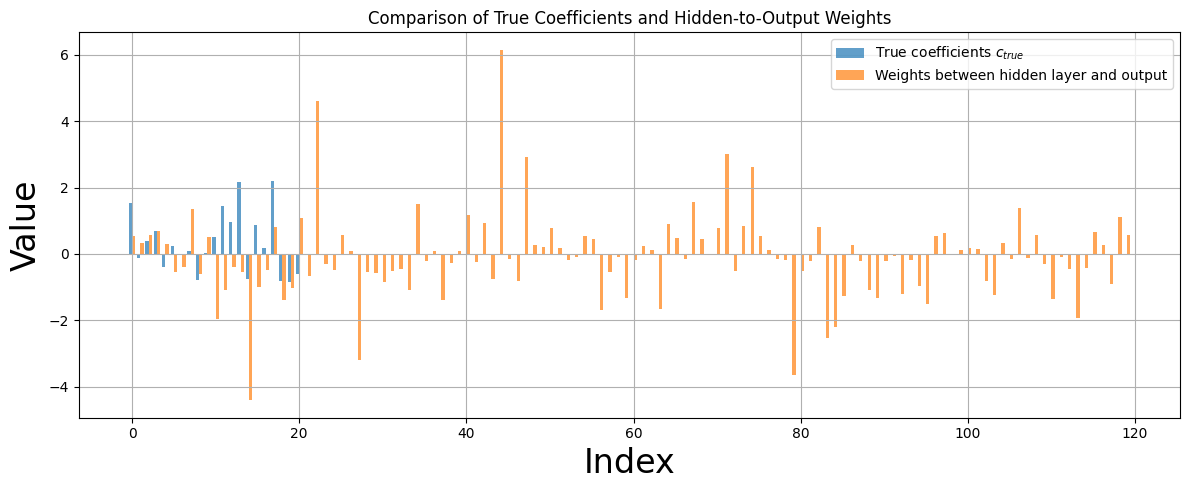

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# -----------------------------
# Histogram: c_true vs W2
# -----------------------------
# Unpack W2 from final parameters
W1, b1, W2, b2 = net.unpack_parameters(final_params)

# Flatten W2 (hidden-to-output weights) to 1D
W2_flat = W2.flatten()

# Pad both vectors to same length for plotting
len_c = len(c_true)
len_w = len(W2_flat)
max_len = max(len_c, len_w)

c_padded = np.pad(c_true, (0, max_len - len_c), 'constant')
w_padded = np.pad(W2_flat, (0, max_len - len_w), 'constant')

# Plotting
plt.figure(figsize=(12, 5))
indices = np.arange(max_len)

bar_width = 0.4
plt.bar(indices - bar_width/2, c_padded, width=bar_width, label='True coefficients $c_{true}$', alpha=0.7)
plt.bar(indices + bar_width/2, w_padded, width=bar_width, label='Weights between hidden layer and output', alpha=0.7)

plt.xlabel('Index', fontsize=24)
plt.ylabel('Value', fontsize=24)
plt.title('Comparison of True Coefficients and Hidden-to-Output Weights')
plt.legend()
plt.grid(True)
plt.tight_layout()
# Save the plot as a PDF
plt.savefig('nn_coefficient.pdf')
plt.show()

from google.colab import files
files.download("nn_coefficient.pdf")